*[This contains information from 'uv_index' API from https://developers.data.gov.sg/environment/uv-index which is made available under the terms of the Singapore Open Data Licence version 1.0 https://data.gov.sg/open-data-licence]*

The UV Index is recorded for every hour from 7am to 7pm (SG Time). 

In [1]:
import urllib.request
from urllib.request import Request, urlopen
import json
import ssl
import pprint
import pytz
import datetime
import pandas as pd
import numpy as np

now = datetime.datetime.now()
today = datetime.date.today()
yesterday = today - datetime.timedelta(1)
#when the data are pulled before 7am, it will show yesterday's data instead
if datetime.datetime.time(now)<datetime.time(7,0,0):
    url = 'https://api.data.gov.sg/v1/environment/uv-index?date=%s'%yesterday
else:
    url = 'https://api.data.gov.sg/v1/environment/uv-index?date=%s'%today

url_request = Request(url, headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})
webpage = urlopen(url_request).read()
data = json.loads(webpage)
    
#importing API
# with urllib.request.urlopen(url) as url:
#     data = json.loads(url.read().decode())
#     #pprint.pprint(data) #print into more readable json format

#choose the latest dataset
index_dict = data['items'][-1]['index']
index_df = pd.DataFrame(index_dict)
index_df = index_df.sort_values('timestamp',ascending=True).reset_index(drop=True)

tz = pytz.timezone('Singapore')
timestamp = pd.to_datetime(index_df['timestamp']).apply(lambda x: x.tz_localize('UTC').tz_convert(tz))
index_df['timestamp'] = timestamp

#add new separate columns for date and time
index_df['date'] = index_df['timestamp'].dt.date
index_df['time'] = index_df['timestamp'].dt.time

#creating new column for uv index category
category = []
for item in index_df['value']:
    if item >= 11:
        category.append('extreme')
    elif np.logical_and(item>=8,item<=10):
        category.append('very high')
    elif np.logical_and(item>=6,item<=7):
        category.append('high')
    elif np.logical_and(item>=3, item<=5):
        category.append('moderate')
    else: 
        category.append('low')
index_df['category'] = category

print(index_df)

                   timestamp  value        date      time   category
0  2018-03-04 07:00:00+08:00      0  2018-03-04  07:00:00        low
1  2018-03-04 08:00:00+08:00      0  2018-03-04  08:00:00        low
2  2018-03-04 09:00:00+08:00      0  2018-03-04  09:00:00        low
3  2018-03-04 10:00:00+08:00      3  2018-03-04  10:00:00   moderate
4  2018-03-04 11:00:00+08:00      7  2018-03-04  11:00:00       high
5  2018-03-04 12:00:00+08:00     12  2018-03-04  12:00:00    extreme
6  2018-03-04 13:00:00+08:00     14  2018-03-04  13:00:00    extreme
7  2018-03-04 14:00:00+08:00     10  2018-03-04  14:00:00  very high
8  2018-03-04 15:00:00+08:00      8  2018-03-04  15:00:00  very high
9  2018-03-04 16:00:00+08:00      7  2018-03-04  16:00:00       high
10 2018-03-04 17:00:00+08:00      4  2018-03-04  17:00:00   moderate
11 2018-03-04 18:00:00+08:00      1  2018-03-04  18:00:00        low
12 2018-03-04 19:00:00+08:00      0  2018-03-04  19:00:00        low


Bar Plot Using matplotlib.pyplot

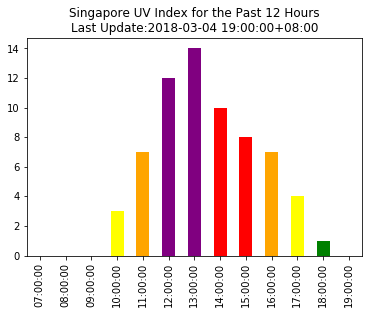

In [4]:
import matplotlib.pyplot as plt

#color codes based on the index level
colors =[]
for item in index_df['value']:
    if item >= 11:
        colors.append('purple')
    elif np.logical_and(item>=8,item<=10):
        colors.append('red')
    elif np.logical_and(item>=6,item<=7):
        colors.append('orange')
    elif np.logical_and(item>=3, item<=5):
        colors.append('yellow')
    else: 
        colors.append('green')
        
last_update = index_df['timestamp'].max()

ax=index_df['value'].plot.bar(color=colors)
ax.set_xticklabels(index_df['time'], rotation=90)
ax.set_title('Singapore UV Index for the Past 12 Hours\nLast Update:%s'%(last_update))
plt.show()

Bar Plot Using Plotly

In [5]:
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

colors =[]
for item in index_df['value']:
    if item >= 11:
        colors.append('purple')
    elif np.logical_and(item>=8,item<=10):
        colors.append('red')
    elif np.logical_and(item>=6,item<=7):
        colors.append('orange')
    elif np.logical_and(item>=3, item<=5):
        colors.append('yellow')
    else: 
        colors.append('green')

last_update = index_df['timestamp'].max()

#initialize plot offline in Jupyter Notebook
init_notebook_mode(connected=True)

data = [go.Bar(x=index_df.time, 
            y=index_df.value,
            marker=dict(
                color=colors,
            ),
            text = index_df['category']
          )]

last_update = index_df['timestamp'].max()
layout = go.Layout(
    title='Singapore UV Index for the Past 12 Hours (Last Update:%s)'%(last_update),
    xaxis=dict(
        tickangle=-90,)
)
fig = go.Figure(data=data, layout=layout)    
iplot(fig, filename = 'jupyter/uv_index_bar')